<a href="https://colab.research.google.com/github/yahal2005/Facial-Emotion-Recognition/blob/1-using-lbp-for-ck-dataset/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/Colab_Notebooks/fer'

In [5]:

haarcascade_path = os.path.join(base_path, 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(haarcascade_path)

In [6]:
def load_and_detect_faces(folder_path):
  images = []
  labels = []
  for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)
    if os.path.isdir(label_path):
      for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
          for (x, y, w, h) in faces:
            face_region = img[y:y+h, x:x+w]
            images.append(face_region)
            labels.append(label)
  return images, labels

In [7]:
train_folder_path = os.path.join(base_path, 'CK_dataset/train')
test_folder_path = os.path.join(base_path, 'CK_dataset/test')

In [8]:
x_train, y_train = load_and_detect_faces(train_folder_path)
x_test, y_test = load_and_detect_faces(test_folder_path)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def preprocess_images(images):
  preprocess_images = []
  for img in images:
    img = cv2.equalizeHist(img)
    preprocess_images.append(img)
  return preprocess_images

In [10]:
from cv2.dnn import imagesFromBlob
radius = 1
n_points = 8 * radius

def extract_lbp_features(images):
  lbp_features = []
  for img in images:
    img = cv2.resize(img,(64,64))
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    lbp_features.append(hist)
  return np.array(lbp_features)

In [11]:
x_train_features = extract_lbp_features(x_train)
x_test_features = extract_lbp_features(x_test)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale'))

svm_classifier.fit(x_train_features, y_train)
y_pred = svm_classifier.predict(x_test_features)

svm_classifier.fit(x_train_features, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=7))])

In [13]:
y_pred = svm_classifier.predict(x_test_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
print(len(y_test))
print(conf_matrix)

Accuracy: 39.16%
143
[[ 5  0  7  5  1  0]
 [ 1  0  0  4  2  0]
 [ 2  0 13  7  0  8]
 [ 3  0  3 18  1 11]
 [ 1  0  4  4  5  3]
 [ 2  0  6 11  1 15]]


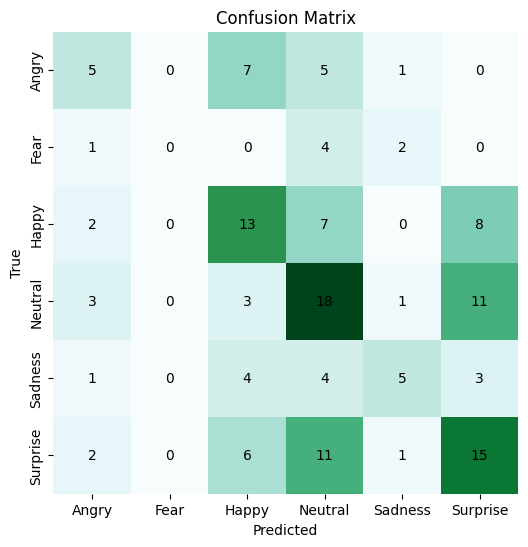

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

plt.figure(figsize=(6, 6))
ax = sns.heatmap(conf_matrix, annot=False, cmap='BuGn', xticklabels=class_names, yticklabels=class_names, cbar=False)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j+0.5, i+0.5, f"{count}", ha='center', va='center', color='black', fontsize=10)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

In [20]:
face_cascade = cv2.CascadeClassifier(haarcascade_path)

def preprocess_and_extract_features(face_img):
  face_img = cv2.resize(face_img,(64,64))
  lbp = local_binary_pattern(face_img, n_points, radius, method='uniform')
  (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-6)
  return hist.reshape(1,-1)

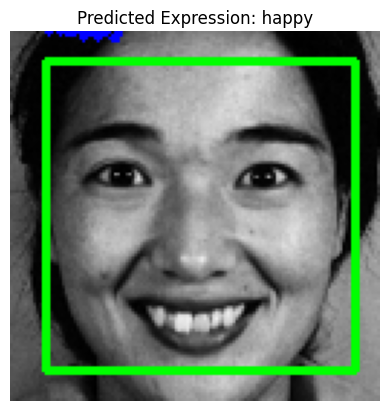

In [21]:
def predict_emotion(image_path, model):
  img = cv2.imread(image_path)
  if img is None:
    raise ValueError("Image not found or could not be loaded")

  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

  if len(faces) == 0:
    print("No faces detected in the image.")
    return

  for (x,y,w,h) in faces:
    face_region = gray_img[y:y+h, x:x+w]

    features = preprocess_and_extract_features(face_region)
    predicted_expression = model.predict(features)[0]

    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.putText(img, predicted_expression, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)

  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_rgb)
  plt.title(f"Predicted Expression: {predicted_expression}")
  plt.axis("off")
  plt.show()

image_path = os.path.join(base_path, 'testimages/27.tiff')
predict_emotion(image_path, svm_classifier)